In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import preprocessing

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
device

'cpu'

In [3]:
#based on https://towardsdatascience.com/build-a-simple-neural-network-using-pytorch-38c55158028d
n_input, n_hidden, n_hidden2, n_out, batch_size, learning_rate, momentum, num_workers, dropout = 9, 30, 11, 2, 100, 0.005, 0.95, 0, 0

In [4]:
full_pd = pd.read_csv('../Dataset_237k.csv')
full_tensor = torch.tensor(full_pd.to_numpy()).float()
full_pd.shape

(237485, 11)

In [5]:
scaler = preprocessing.MinMaxScaler()

In [6]:
full_scaled = torch.tensor(scaler.fit_transform(full_tensor)).float()
full_scaled[:10, :]

tensor([[4.2857e-01, 4.2857e-01, 0.0000e+00, 2.8571e-01, 6.3049e-02, 9.6665e-01,
         2.5893e-01, 3.2685e-01, 2.7513e-03, 8.6700e-02, 5.3700e-01],
        [0.0000e+00, 0.0000e+00, 1.4286e-01, 1.4286e-01, 3.1193e-01, 4.0891e-01,
         7.9886e-01, 7.3915e-01, 3.0244e-03, 5.5611e-02, 5.8032e-01],
        [4.2857e-01, 0.0000e+00, 2.8571e-01, 5.7143e-01, 3.7063e-01, 4.2484e-01,
         8.6386e-01, 7.3438e-01, 4.4560e-04, 1.0000e+00, 5.4318e-03],
        [2.8571e-01, 8.5714e-01, 0.0000e+00, 8.5714e-01, 6.6664e-02, 6.9349e-01,
         5.0336e-01, 6.1156e-01, 4.1963e-05, 1.0000e+00, 5.3588e-03],
        [1.4286e-01, 7.1429e-01, 7.1429e-01, 1.4286e-01, 5.7649e-02, 9.4421e-01,
         5.6026e-01, 7.1128e-01, 3.8886e-04, 1.0000e+00, 5.4436e-03],
        [2.8571e-01, 0.0000e+00, 5.7143e-01, 5.7143e-01, 3.2106e-01, 3.5409e-01,
         5.8771e-01, 6.2953e-01, 1.2502e-03, 6.7290e-01, 1.2079e-01],
        [4.2857e-01, 1.4286e-01, 4.2857e-01, 4.2857e-01, 9.0662e-01, 2.9580e-01,
         1.09

In [7]:
train_n = {"data": full_scaled[:80000, :9].to(device), "target": full_scaled[:80000, 9:].to(device)}
test_n = {"data": full_scaled[:-10000, :9].to(device), "target": full_scaled[:-10000, 9:].to(device)}

test_n["data"].requires_grad=False
test_n["target"].requires_grad=False

train, validate, test = torch.utils.data.random_split(full_scaled, [200000, 27485, 10000])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

In [8]:
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.Dropout(p=dropout),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden2),
                      nn.ReLU(),
                      nn.Linear(n_hidden2, n_out),
                      nn.Sigmoid())

model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=9, out_features=30, bias=True)
  (1): Dropout(p=0, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=11, bias=True)
  (4): ReLU()
  (5): Linear(in_features=11, out_features=2, bias=True)
  (6): Sigmoid()
)


In [9]:
loss_function = nn.HuberLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [10]:
#torch.multiprocessing.set_start_method('spawn')
import time

tim = time.time()

epochs = 100

losses = []
test_losses = []
for i in range(1, epochs + 1):
    loss_sum = 0
    model.train()
    for j, item in enumerate(train_loader):
        train_x, train_y = item[:, :9], item[:, 9:]
        
        # train_x = train_x.to(device)
        # train_y = train_y.to(device)
        
        pred_y = model(train_x)
        loss = loss_function(pred_y, train_y)
        losses.append(loss.item())

        model.zero_grad()
        loss.backward()

        optimizer.step()
        loss_sum = loss.item()

    model.eval()
    test_pred_y = model(test_n["data"])
    test_loss = loss_function(test_pred_y, test_n["target"])
    test_losses.append(test_loss)

    accuracy_arr = full_tensor[-20000:, :]

    inf_accuracy_arr = scaler.inverse_transform(torch.cat((accuracy_arr[:, :9], model(torch.Tensor(scaler.transform(accuracy_arr)[:, :9]))), 1).detach().numpy())

    true_loss_throughput = ((accuracy_arr[:, 9] - inf_accuracy_arr[:, 9]).abs() / accuracy_arr[:, 9] < 0.05).long().float()
    true_loss_delay = ((accuracy_arr[:, 10] - inf_accuracy_arr[:, 10]).abs() / accuracy_arr[:, 10] < 0.05).long().float()

    print(f"Epoch {i:2}/{epochs} | "
          f"training loss: {loss_sum:.5f} | "
          f"test loss: {test_loss:.5f} | "
          f"true loss throughput: {true_loss_throughput.mean():.5f} | "
          f"true loss delay: {true_loss_delay.mean():.5f}")

print(time.time() - tim)

Epoch  1/100 | training loss: 0.05015 | test loss: 0.05444 | true loss throughput: 0.01660 | true loss delay: 0.01035
Epoch  2/100 | training loss: 0.04555 | test loss: 0.04886 | true loss throughput: 0.02035 | true loss delay: 0.01025
Epoch  3/100 | training loss: 0.04289 | test loss: 0.04619 | true loss throughput: 0.02145 | true loss delay: 0.01040
Epoch  4/100 | training loss: 0.04192 | test loss: 0.04511 | true loss throughput: 0.02220 | true loss delay: 0.01085
Epoch  5/100 | training loss: 0.04112 | test loss: 0.04417 | true loss throughput: 0.02220 | true loss delay: 0.01280
Epoch  6/100 | training loss: 0.04012 | test loss: 0.04298 | true loss throughput: 0.02245 | true loss delay: 0.01325
Epoch  7/100 | training loss: 0.03859 | test loss: 0.04127 | true loss throughput: 0.02275 | true loss delay: 0.01200
Epoch  8/100 | training loss: 0.03652 | test loss: 0.03883 | true loss throughput: 0.02305 | true loss delay: 0.01345
Epoch  9/100 | training loss: 0.03374 | test loss: 0.035

In [11]:
#losses = []
#test_losses = []
#for i in range(100):
#    for j in range(0, train_n["data"].shape[0], batch_size):
#        train_x, train_y = train_n["data"][j:j+batch_size], train_n["target"][j:j+batch_size]
#        
#        pred_y = model(train_x)
#        loss = loss_function(pred_y, train_y)
#        losses.append(loss.item())
#
#        model.zero_grad()
#        loss.backward()
#
#        optimizer.step()
#
#    test_pred_y = model(test_n["data"])
#    test_loss = loss_function(test_pred_y, test_n["target"])
#    test_losses.append(test_loss)

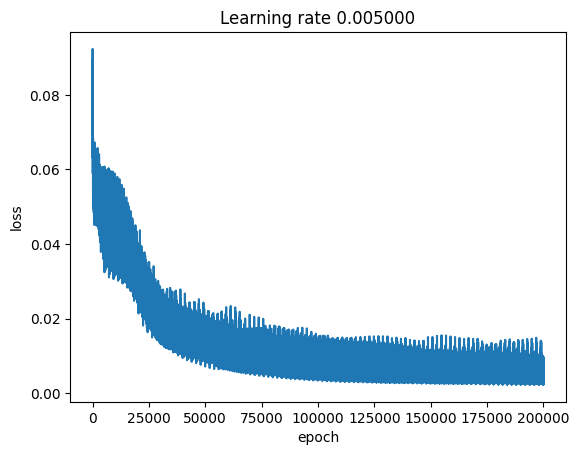

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [13]:
test_losses

[tensor(0.0544, grad_fn=<HuberLossBackward0>),
 tensor(0.0489, grad_fn=<HuberLossBackward0>),
 tensor(0.0462, grad_fn=<HuberLossBackward0>),
 tensor(0.0451, grad_fn=<HuberLossBackward0>),
 tensor(0.0442, grad_fn=<HuberLossBackward0>),
 tensor(0.0430, grad_fn=<HuberLossBackward0>),
 tensor(0.0413, grad_fn=<HuberLossBackward0>),
 tensor(0.0388, grad_fn=<HuberLossBackward0>),
 tensor(0.0355, grad_fn=<HuberLossBackward0>),
 tensor(0.0320, grad_fn=<HuberLossBackward0>),
 tensor(0.0290, grad_fn=<HuberLossBackward0>),
 tensor(0.0265, grad_fn=<HuberLossBackward0>),
 tensor(0.0242, grad_fn=<HuberLossBackward0>),
 tensor(0.0219, grad_fn=<HuberLossBackward0>),
 tensor(0.0206, grad_fn=<HuberLossBackward0>),
 tensor(0.0189, grad_fn=<HuberLossBackward0>),
 tensor(0.0181, grad_fn=<HuberLossBackward0>),
 tensor(0.0177, grad_fn=<HuberLossBackward0>),
 tensor(0.0181, grad_fn=<HuberLossBackward0>),
 tensor(0.0184, grad_fn=<HuberLossBackward0>),
 tensor(0.0184, grad_fn=<HuberLossBackward0>),
 tensor(0.018

In [14]:
#                                      bandwidth ↓
model(torch.tensor([1., 1., 1., 1., 1., 1., 1., 100., 1.]))

tensor([0., 0.], grad_fn=<SigmoidBackward0>)

In [15]:
#                                      bandwidth ↓
model(torch.tensor([1., 1., 1., 1., 1., 1., 1., 1000., 1.]))

tensor([0., 0.], grad_fn=<SigmoidBackward0>)

In [16]:
full_scaled[230000:230005, :9]

tensor([[0.0000e+00, 2.8571e-01, 4.2857e-01, 8.5714e-01, 1.7304e-02, 1.2747e-01,
         2.8086e-01, 1.6938e-01, 6.1069e-04],
        [7.1429e-01, 1.4286e-01, 8.5714e-01, 8.5714e-01, 4.1366e-02, 3.1247e-01,
         9.8956e-01, 2.2675e-01, 1.2218e-02],
        [2.8571e-01, 0.0000e+00, 1.4286e-01, 5.7143e-01, 2.6630e-01, 2.7092e-01,
         1.8378e-01, 1.7757e-01, 4.7269e-02],
        [1.4286e-01, 5.7143e-01, 1.0000e+00, 0.0000e+00, 4.3131e-01, 2.3900e-01,
         4.1423e-01, 8.3760e-02, 5.7176e-03],
        [2.8571e-01, 2.8571e-01, 4.2857e-01, 1.0000e+00, 3.2173e-01, 1.1533e-01,
         1.9751e-02, 7.5154e-01, 1.1898e-03]])

In [17]:
inf_scaled = model(full_scaled[230000:230005, :9])
inf_scaled

tensor([[6.2800e-01, 1.9680e-01],
        [4.4569e-03, 1.0843e-01],
        [1.5114e-07, 9.6557e-04],
        [9.4981e-02, 4.7823e-01],
        [9.6983e-01, 4.3306e-02]], grad_fn=<SigmoidBackward0>)

In [18]:
remerged = torch.cat((full_scaled[230000:230005, :9], inf_scaled), 1)
remerged

tensor([[0.0000e+00, 2.8571e-01, 4.2857e-01, 8.5714e-01, 1.7304e-02, 1.2747e-01,
         2.8086e-01, 1.6938e-01, 6.1069e-04, 6.2800e-01, 1.9680e-01],
        [7.1429e-01, 1.4286e-01, 8.5714e-01, 8.5714e-01, 4.1366e-02, 3.1247e-01,
         9.8956e-01, 2.2675e-01, 1.2218e-02, 4.4569e-03, 1.0843e-01],
        [2.8571e-01, 0.0000e+00, 1.4286e-01, 5.7143e-01, 2.6630e-01, 2.7092e-01,
         1.8378e-01, 1.7757e-01, 4.7269e-02, 1.5114e-07, 9.6557e-04],
        [1.4286e-01, 5.7143e-01, 1.0000e+00, 0.0000e+00, 4.3131e-01, 2.3900e-01,
         4.1423e-01, 8.3760e-02, 5.7176e-03, 9.4981e-02, 4.7823e-01],
        [2.8571e-01, 2.8571e-01, 4.2857e-01, 1.0000e+00, 3.2173e-01, 1.1533e-01,
         1.9751e-02, 7.5154e-01, 1.1898e-03, 9.6983e-01, 4.3306e-02]],
       grad_fn=<CatBackward0>)

In [19]:
torch.tensor(scaler.inverse_transform(remerged.detach().numpy())[:, 9:])

tensor([[1.2847e+02, 1.1236e+02],
        [9.1175e-01, 6.1906e+01],
        [3.0919e-05, 5.5125e-01],
        [1.9430e+01, 2.7303e+02],
        [1.9840e+02, 2.4724e+01]])

In [20]:
full_tensor[230000:230005, 9:]

tensor([[146.0171,  81.0928],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [ 15.5708, 219.3682],
        [203.0780,  39.5046]])

In [21]:
myin = torch.tensor([4.,4,2,2,30,20,3600000000, 20000000, 200])

In [22]:
myin2 = torch.cat((myin, torch.tensor([0, 0.])), 0)

In [23]:
myin3 = scaler.transform(myin2.reshape(1,-1))

In [24]:
myins4 = torch.tensor(myin3[:, :9]).float()

In [25]:
model(myins4)

tensor([[0.3341, 0.2941]], grad_fn=<SigmoidBackward0>)